# Prepare data tables for enhancer counting and other information that will be used to generate figures

In [15]:
#import libraries
import pandas as pd
import os
import bioframe as bf
#import key tables
os.chdir(r'Z:\gbaniulyte\MPRA\AM_STARRSeq\final_scripts_fastq\tables')
#this is the original table with seq information
df = pd.read_csv('p63enh_starrseq_info.csv', usecols=['uniqueID', 'obs_score','p63RE_class',
													  'WT', 'mut', 'shuffle','flankShuffle','fullShuffle',
													  'strand','p63RE_chrom','p63RE_start','p63RE_stop'])
#make a long table and reformat
df_long = df.melt(id_vars=['uniqueID', 'obs_score','p63RE_class','strand','p63RE_chrom','p63RE_start','p63RE_stop'],
				  value_vars=['WT', 'mut', 'shuffle','flankShuffle', 'fullShuffle'],
				  var_name='enhancer_variant',
				  value_name='seq')
#add unique id with p63RE locationa and variant
df_long['id'] = df_long.apply(lambda row: row.uniqueID[: row.uniqueID.rfind('_') + 1] + row.enhancer_variant, axis='columns')
df_long['loc'] = df_long.apply(lambda row: row.uniqueID[: row.uniqueID.rfind('_')], axis='columns')
df_long[['p63RE_class', 'p63RE_type']] = df_long.apply(lambda row: [row.p63RE_class[:row.p63RE_class.find('.')],
																	row.p63RE_class[row.p63RE_class.find('.') + 1:]],
													    axis='columns', result_type='expand')
df_long.replace({'unique-p63RE':'Unique p63RE', 'p53+p63RE' : 'p53RE+p63RE'}, inplace=True)
df_long.drop(columns=['uniqueID', ], inplace=True)
#add enhancner GC content (%)
def gc_count(sequence):
	sequence = sequence.upper()
	gc = ((sequence.count('G') + sequence.count('C')) / len(sequence)) * 100
	return gc
df_long['gc'] = df_long.seq.apply(lambda x: gc_count(x))
riege_xls = pd.ExcelFile('elife-63266-supp3-v2.xlsx', engine='openpyxl')
p53_motifs = riege_xls.parse('p53peaks+REs', usecols=['Number of supporting p53 ChIP-seq datasets','p53RE_Chromosome','p53RE_Start','p53RE_End'])
#remove rows with no motif coordinates
p53_motifs = p53_motifs[p53_motifs.p53RE_Start != '-']
#bioframe needs int
p53_motifs =p53_motifs.astype({"p53RE_Start": int, "p53RE_End": int})
p53_p63_overlap = bf.overlap(df_long, p53_motifs,  cols1 = ['p63RE_chrom','p63RE_start','p63RE_stop'],
							  cols2 = ['p53RE_Chromosome','p53RE_Start','p53RE_End'], suffixes = ['','_p53'])
del(riege_xls,p53_motifs)
#save enh id that has p53 ob if they overlap with p63RE
df_long = df_long.merge(p53_p63_overlap[['id','Number of supporting p53 ChIP-seq datasets_p53']], on='id', how='left')
df_long.to_csv('p63enh_starrseq_info_long.csv')
df_long.sample(10)

,obs_score,p63RE_class,strand,p63RE_chrom,p63RE_start,p63RE_stop,enhancer_variant,seq,id,loc,p63RE_type,gc,Number of supporting p53 ChIP-seq datasets_p53
63639,9,primary,+,chr11,79043019,79043038,flankShuffle,ttggccaaattgcgacccacctgttgattgccccctcacagaaacc...,chr11_79043019_79043038_flankShuffle,chr11_79043019_79043038,p53RE+p63RE,52.941176,NaN
3060,16,primary,-,chr8,143385410,143385434,WT,cggggggcacagctgccccgaggggccggctcaaggctgtccctgc...,chr8_143385410_143385434_WT,chr8_143385410_143385434,Unique p63RE,73.333333,NaN
80692,9,primary,-,chr1,191901820,191901839,fullShuffle,tgaggacgagcctgcagttgtttactagtgcctacgcttagtgaac...,chr1_191901820_191901839_fullShuffle,chr1_191901820_191901839,p53RE+p63RE,47.899160,15.0
74645,13,secondary,-,chr11,35894092,35894106,fullShuffle,aggcccttcgagctataagagtctgaaaatacgtcatttcatgtat...,chr11_35894092_35894106_fullShuffle,chr11_35894092_35894106,p53RE+p63RE,54.166667,NaN
29799,9,primary,-,chr2,68368505,68368529,mut,taacagcaaagcctaccatctcattgatcccaggcagcattctgaa...,chr2_68368505_68368529_mut,chr2_68368505_68368529,Unique p63RE,50.000000,NaN
11510,9,quinary,+,chr10,5564328,5564337,WT,cacaagtcagggtgttgcctctgcttacaagcctttggtgactgcc...,chr10_5564328_5564337_WT,chr10_5564328_5564337,p53RE+p63RE,60.504202,5.0
27148,10,tertiary,+,chr11,119229872,119229886,mut,tgggttcaagtgattctcctgcctcagcctcccgagtagctggaat...,chr11_119229872_119229886_mut,chr11_119229872_119229886,Unique p63RE,43.333333,NaN
46853,9,secondary,+,chr17,31492027,31492041,shuffle,aaaccagcaaagggcacgccggcgatgtgcatacagctgtgtctct...,chr17_31492027_31492041_shuffle,chr17_31492027_31492041,p53RE+p63RE,62.500000,NaN
23606,13,primary,-,chr6,157260962,157260981,mut,tgcatgattagacttgcttgatcttcccctctgcccttgccaggag...,chr6_157260962_157260981_mut,chr6_157260962_157260981,p53RE+p63RE,56.302521,NaN
71417,17,primary,+,chr7,99561554,99561573,fullShuffle,ctgtgcgtgacaaccaacagtatctaataagtttacgggccatatg...,chr7_99561554_99561573_fullShuffle,chr7_99561554_99561573,p53RE+p63RE,45.378151,7.0


# Prepare raw counts table from all p63 enhancer STARRseq experiments

In [1]:
#import libraries
import pandas as pd
import os
#import key tables
os.chdir(r'Z:\gbaniulyte\MPRA\AM_STARRSeq\final_scripts_fastq\tables')
counts_path = r'Z:\gbaniulyte\MPRA\AM_STARRSeq\final_scripts_fastq\tables\read_counts'
#this is the original table with seq information
df = pd.read_csv('p63enh_starrseq_info_long.csv', usecols=['seq', 'id'])
df[['loc','enhancer_variant']] = df.apply(lambda row: [row.id[:row.id.rfind('_')],
													   row.id[row.id.rfind('_') + 1 :]],
										  				axis='columns', result_type='expand')
df.seq = df.seq.apply(lambda x: x[:101].upper())
#gather all the counts tables for each sample
count_tbl = os.listdir(counts_path)
for tbl in count_tbl:
	counts = pd.read_csv(os.path.join(counts_path,tbl), names=['seq',tbl[:tbl.find('.csv')]])
	df = df.merge(counts, how='left', on='seq')
#df.to_csv('p63enh_starrseq_raw_counts.csv')
df.sample(5)

,seq,id,loc,enhancer_variant,HaCaT_1_count,HaCaT_2_count,MCF10AGus_count,MCF10Ap53KO_1_count,MCF10Ap53KO_2_count,MCF10ATAp63B_count,MCF10A_1_count,MCF10A_2_count,plasmid_1_count,plasmid_2_count,SCC25_1_count,SCC25_2_count
69090,ACGAGTCCGCTGAAGACCGTCACAACTTCCGTCATCCGTCCGCCTA...,chr9_13027983_13028007_flankShuffle,chr9_13027983_13028007,flankShuffle,559,958,927,595,1062,409,2159,1210,1955,808,1997,711
25839,CAATGGCCCTGGGACACAGACGTGGAGGCAGAGATTACAGCGAAGC...,chr16_29145942_29145961_mut,chr16_29145942_29145961,mut,913,804,569,1217,1556,649,1819,2182,2012,688,1293,1503
12884,ACTAGGAGTGATTTAAACTACGTGGACATTTATTATCTCCTGTATT...,chr3_98778884_98778908_WT,chr3_98778884_98778908,WT,1525,1955,1767,3538,1933,988,4389,4406,6156,2316,5640,3157
41945,TTCCTGGAAGAGGGTGGAAGTGAGATCAGTACAGACACGTGATCTG...,chr20_35318743_35318757_shuffle,chr20_35318743_35318757,shuffle,344,530,560,789,2088,583,827,1662,1755,550,1488,805
83946,CGTGGAAAGTGCTTTTGGAAAAGTTGCCGCGGGATTGTGGTAGAGC...,chr13_40252431_40252450_fullShuffle,chr13_40252431_40252450,fullShuffle,452,1098,999,1342,1876,839,3229,2769,3222,1232,1327,1104


# Prepare normalized counts table from all p63 enhancer STARRseq experiments.
- Used minimal read threshold as 5 for DNA dn RNA reads
- Normalize each sample to total reads in that sample pool
- Then normalize RNA reads (MCF10A, MCF10Ap53KO, HaCaT, SCC25, MCF10A + Gus & MCF10A + TAp63β) DNA reads.
- All cell types except HaCaT were trasnfected with plasmid pool 1 so they are normalized to plasmid 1, HaCaTs normalized to plasmid 2 DNA counts.
- Create separate raw read-filtered tables as we're only considering 2 or 3 cell types for each figures and SCC25 cells trasfected poorly and would lower usable enhacner numbers

In [2]:
#import libraries
import pandas as pd
import os
import numpy as np
import warnings
warnings.filterwarnings('ignore')
#import key tables
os.chdir(r'Z:\gbaniulyte\MPRA\AM_STARRSeq\final_scripts_fastq\tables')
counts_path = r'Z:\gbaniulyte\MPRA\AM_STARRSeq\final_scripts_fastq\tables\read_counts'
min_reads = 5
#this is the original table with seq information
df = pd.read_csv('p63enh_starrseq_raw_counts.csv', index_col=0)
df.drop(columns=['seq'], inplace=True)
#get total read counts per pool
total_counts = {'MCF10A_1_count':df.MCF10A_1_count.sum(), 'MCF10A_2_count':df.MCF10A_2_count.sum(),
		 'MCF10Ap53KO_1_count':df.MCF10Ap53KO_1_count.sum(),'MCF10Ap53KO_2_count':df.MCF10Ap53KO_2_count.sum(),
		 'HaCaT_1_count':df.HaCaT_1_count.sum(),'HaCaT_2_count':df.HaCaT_2_count.sum(),
		 'SCC25_1_count':df.SCC25_1_count.sum(),'SCC25_2_count':df.SCC25_2_count.sum(),
		 'plasmid_1_count':df.plasmid_1_count.sum(),'plasmid_2_count':df.plasmid_2_count.sum(),
		 'MCF10AGus_count':df.MCF10AGus_count.sum(), 'MCF10ATAp63B_count':df.MCF10ATAp63B_count.sum()}
#organize and name all the columns
col_list = {'new_col':['RNA/DNA_MCF10A_1','RNA/DNA_MCF10A_2','RNA/DNA_MCF10Ap53KO_1','RNA/DNA_MCF10Ap53KO_2','RNA/DNA_MCF10AGus','RNA/DNA_MCF10ATAp63B',
					    'RNA/DNA_SCC25_1', 'RNA/DNA_SCC25_2','RNA/DNA_HaCaT_1','RNA/DNA_HaCaT_2','Plasmid_1','Plasmid_2'],
			'count_col':['MCF10A_1_count','MCF10A_2_count','MCF10Ap53KO_1_count','MCF10Ap53KO_2_count','MCF10AGus_count','MCF10ATAp63B_count',
				 		 'SCC25_1_count','SCC25_2_count','HaCaT_1_count','HaCaT_2_count','plasmid_1_count','plasmid_2_count']}
df_norm = df.copy()
#normalize to total reads
for n in range(0,len(col_list['new_col'])):
	df_norm[col_list['new_col'][n]] = df_norm[col_list['count_col'][n]].div(total_counts[col_list['count_col'][n]])
#normalize all MCFs to plasmid pool 1
df_norm[col_list['new_col'][0:8]] = df_norm[col_list['new_col'][0:8]].div(df_norm['Plasmid_1'].values, axis='index')
#fresh pool of DNA was maxipreped for transfection into HaCats
df_norm[['RNA/DNA_HaCaT_1','RNA/DNA_HaCaT_2']] = df_norm[['RNA/DNA_HaCaT_1','RNA/DNA_HaCaT_2']].div(
	df_norm['Plasmid_2'].values, axis='index')
#filter out based on min read threshold
print('Number of enhancers before filtering:', len(df_norm))
#create different tables for matched enhancers because SCC25 had signf. lower read counts
df_norm_1 = df_norm[(df_norm.plasmid_1_count > min_reads) &
		(df_norm.MCF10A_1_count > min_reads) & (df_norm.MCF10A_2_count > min_reads) &
 		(df_norm.MCF10Ap53KO_1_count > min_reads) & (df_norm.MCF10Ap53KO_2_count > min_reads)]
print('Number of enhancers after filtering for MCF10A WT and p53KO:', len(df_norm_1))
df_norm_1.drop(columns=col_list['count_col'] + ['Plasmid_1','Plasmid_2'], inplace=True)
df_norm_2 = df_norm[(df_norm.plasmid_1_count > min_reads) & (df_norm.plasmid_2_count > min_reads) &
 		(df_norm.MCF10Ap53KO_1_count > min_reads) & (df_norm.MCF10Ap53KO_2_count > min_reads) &
		(df_norm.HaCaT_1_count > min_reads) & (df_norm.HaCaT_2_count > min_reads) &
		(df_norm.SCC25_1_count > min_reads) & (df_norm.SCC25_2_count > min_reads)]
print('Number of enhancers after filtering for MCF10A p53KO, HaCaT and SCC25:', len(df_norm_2))
df_norm_2.drop(columns=col_list['count_col'] + ['Plasmid_1','Plasmid_2'], inplace=True)
df_norm_3 = df_norm[(df_norm.plasmid_1_count > min_reads) &
		(df_norm.MCF10AGus_count > min_reads) & (df_norm.MCF10ATAp63B_count > min_reads)]
print('Number of enhancers after filtering for MCF10A Gus and TAp63B:', len(df_norm_3))
df_norm_3.drop(columns=col_list['count_col'] + ['Plasmid_1','Plasmid_2'], inplace=True)
df_norm_3.sample(5)

Number of enhancers before filtering: 86550
Number of enhancers after filtering for MCF10A WT and p53KO: 81867
Number of enhancers after filtering for MCF10A p53KO, HaCaT and SCC25: 58259
Number of enhancers after filtering for MCF10A Gus and TAp63B: 83167


,id,loc,enhancer_variant,RNA/DNA_MCF10A_1,RNA/DNA_MCF10A_2,RNA/DNA_MCF10Ap53KO_1,RNA/DNA_MCF10Ap53KO_2,RNA/DNA_MCF10AGus,RNA/DNA_MCF10ATAp63B,RNA/DNA_SCC25_1,RNA/DNA_SCC25_2,RNA/DNA_HaCaT_1,RNA/DNA_HaCaT_2
13869,chr1_40890062_40890076_WT,chr1_40890062_40890076,WT,0.740127,0.528800,0.432679,0.475164,0.739241,0.188971,0.489176,0.785243,0.429115,0.510577
55817,chr6_161375409_161375428_flankShuffle,chr6_161375409_161375428,flankShuffle,0.688981,0.653830,1.107887,0.669541,0.689230,0.947056,0.463220,0.761670,0.696045,0.548090
83475,chr10_79454556_79454575_fullShuffle,chr10_79454556_79454575,fullShuffle,0.584642,0.657283,0.470897,0.982210,0.869058,0.504326,0.291994,1.044609,1.461568,1.234655
73705,chr16_53768760_53768784_fullShuffle,chr16_53768760_53768784,fullShuffle,0.635600,0.387273,0.339047,0.729203,0.600748,0.357635,0.000961,1.021531,0.975654,0.323150
41357,chr10_121781335_121781359_shuffle,chr10_121781335_121781359,shuffle,0.692604,0.635498,0.785038,0.920904,0.803168,0.567769,1.798843,0.931615,0.942481,1.045066


[None, None, (0.0061991357971190415, 100), (0.001826533991111655, 100)]

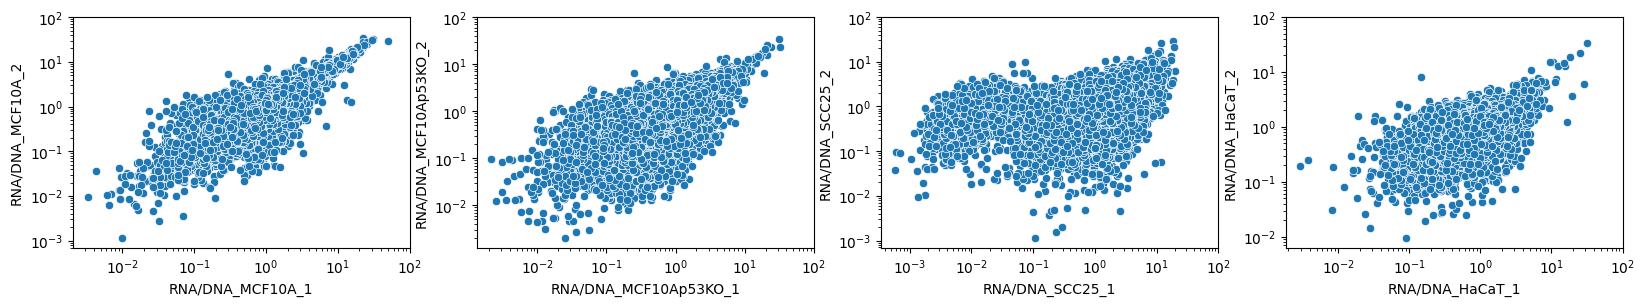

In [4]:
#Check replicates
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
fig, (ax,ax1,ax3,ax4) = plt.subplots(nrows=1, ncols = 4,figsize=(20,3))
sns.scatterplot(data=df_norm_1, x='RNA/DNA_MCF10A_1',y='RNA/DNA_MCF10A_2',ax=ax).set(yscale='log',xscale='log',ylim=(0,100),xlim=(0,100))
sns.scatterplot(data=df_norm_1, x='RNA/DNA_MCF10Ap53KO_1',y='RNA/DNA_MCF10Ap53KO_2',ax=ax1).set(yscale='log',xscale='log',ylim=(0,100),xlim=(0,100))
sns.scatterplot(data=df_norm_2, x='RNA/DNA_SCC25_1',y='RNA/DNA_SCC25_2',ax=ax3).set(yscale='log',xscale='log',ylim=(0,100),xlim=(0,100))
sns.scatterplot(data=df_norm_2, x='RNA/DNA_HaCaT_1',y='RNA/DNA_HaCaT_2',ax=ax4).set(yscale='log',xscale='log',ylim=(0,100),xlim=(0,100))

## Match enhancers for:
- Replicates
- MCF10A WT and KO for all 5 variants
- Separately MCF10A p53KO, HaCaT and SCC25 for WT and mut only
- Separately MCF10A Gus or TAp6B WT and Mut

In [3]:
#move enh variant into columns to make it easier to match enahncers in each sample pool
#MCF10A WT and KO, all variants
wide_mcf = df_norm_1.pivot(index=['loc'], columns=['enhancer_variant'],
		 values=['RNA/DNA_MCF10A_1','RNA/DNA_MCF10A_2',
		   'RNA/DNA_MCF10Ap53KO_1','RNA/DNA_MCF10Ap53KO_2']).reset_index()
#MCF10A p53KO, HaCaT, SCC25, WT and mut variants
wide_mhs = df_norm_2[df_norm_2.enhancer_variant.isin(['WT','mut'])].pivot(index=['loc'], columns=['enhancer_variant'],
		 values=['RNA/DNA_MCF10Ap53KO_1','RNA/DNA_MCF10Ap53KO_2',
		   'RNA/DNA_HaCaT_1','RNA/DNA_HaCaT_2',
		   'RNA/DNA_SCC25_1','RNA/DNA_SCC25_2']).reset_index()
#MCF10A Gus and TAp63B overexpression, WT and mut variants
wide_overex = df_norm_3[df_norm_3.enhancer_variant.isin(['WT','mut'])].pivot(index=['loc'], columns=['enhancer_variant'],
		 values=['RNA/DNA_MCF10AGus','RNA/DNA_MCF10ATAp63B']).reset_index()
#drop NaNs in each row to remove enhancers that don't have a match in replicate/cell type/enh variant
wide_mcf.dropna(how='any', inplace=True)
wide_mhs.dropna(how='any', inplace=True)
wide_overex.dropna(how='any', inplace=True)
print('Number of unique enhancer locations in MCF10As WT and p53KO:', wide_mcf['loc',''].nunique())
print('Number of unique enhancer locations in MCF10As p53KO, HaCaT and SCC25:', wide_mhs['loc',''].nunique())
print('Number of unique enhancer locations in MCF10As Gus and TAp63B:', wide_overex['loc',''].nunique())
wide_mhs.head(5)

Number of unique enhancer locations in MCF10As WT and p53KO: 13696
Number of unique enhancer locations in MCF10As p53KO, HaCaT and SCC25: 8566
Number of unique enhancer locations in MCF10As Gus and TAp63B: 16143


loc RNA/DNA_MCF10Ap53KO_1            \
enhancer_variant                                               WT       mut   
0                 chr10_100043539_100043558              1.319655  0.560156   
1                 chr10_100157341_100157365              1.671221  1.560248   
2                 chr10_100286133_100286152              0.559138  0.383291   
3                 chr10_100373316_100373330              3.184686  1.870014   
6                 chr10_100886190_100886214              0.464043  0.313704   

                 RNA/DNA_MCF10Ap53KO_2           RNA/DNA_HaCaT_1            \
enhancer_variant                    WT       mut              WT       mut   
0                             1.137255  0.733605        1.058830  0.638685   
1                             1.620464  1.152133        1.614002  0.918617   
2                             0.543610  0.348498        0.416229  0.338045   
3                             2.757653  1.644806        1.168821  1.835282   
6                             0.345795  0.545380        0.827458  1.056786   

                 RNA/DNA_HaCaT_2           RNA/DNA_SCC25_1            \
enhancer_variant              WT       mut              WT       mut   
0                       1.254867  0.879382        0.390366  1.393339   
1                       1.724374  1.219318        0.596935  0.666459   
2                       0.484690  0.366422        1.037235  0.516950   
3                       1.100346  1.115179        1.876799  1.543624   
6                       0.841565  1.224738        1.814806  1.167748   

                 RNA/DNA_SCC25_2            
enhancer_variant              WT       mut  
0                       1.058964  0.403181  
1                       0.402588  1.351475  
2                       0.841603  0.651545  
3                       2.005602  3.341386  
6                       0.511488  0.283157

## Average all the replicates and create a long table

In [4]:
#use the wide tables to get a list of enahcners to keep (matched enhancers)
to_keep_mcf = wide_mcf['loc', ''].tolist()
to_keep_mhs = wide_mhs['loc', ''].tolist()
to_keep_overex = wide_overex['loc', ''].tolist()
#average replicates for each cell type
df_norm_2 = df_norm_2[df_norm_2.enhancer_variant.isin(['WT', 'mut'])]
df_norm_3 = df_norm_3[df_norm_3.enhancer_variant.isin(['WT', 'mut'])]
df_norm_1 = df_norm_1[df_norm_1['loc'].isin(to_keep_mcf)]
df_norm_2 = df_norm_2[df_norm_2['loc'].isin(to_keep_mhs)]
df_norm_3 = df_norm_3[df_norm_3['loc'].isin(to_keep_overex)]
df_norm_1['RNA/DNA_MCF10A'] = df_norm_1[['RNA/DNA_MCF10A_1','RNA/DNA_MCF10A_2']].mean(axis=1)
df_norm_1['RNA/DNA_MCF10Ap53KO'] = df_norm_1[['RNA/DNA_MCF10Ap53KO_1','RNA/DNA_MCF10Ap53KO_2']].mean(axis=1)
df_norm_2['RNA/DNA_MCF10Ap53KO'] = df_norm_2[['RNA/DNA_MCF10Ap53KO_1','RNA/DNA_MCF10Ap53KO_2']].mean(axis=1)
df_norm_2['RNA/DNA_HaCaT'] = df_norm_2[['RNA/DNA_HaCaT_1','RNA/DNA_HaCaT_2']].mean(axis=1)
df_norm_2['RNA/DNA_SCC25'] = df_norm_2[['RNA/DNA_SCC25_1','RNA/DNA_SCC25_2']].mean(axis=1)
#Gus and TAp63B overexpression is only a single replicate
df_norm_1.drop(columns=col_list['new_col'][0:-2],inplace=True)
df_norm_2.drop(columns=col_list['new_col'][0:-2],inplace=True)
df_norm_3.drop(columns=['RNA/DNA_MCF10A_1','RNA/DNA_MCF10A_2','RNA/DNA_MCF10Ap53KO_1','RNA/DNA_MCF10Ap53KO_2',
					    'RNA/DNA_SCC25_1', 'RNA/DNA_SCC25_2','RNA/DNA_HaCaT_1','RNA/DNA_HaCaT_2'],inplace=True)
df_norm_3

,id,loc,enhancer_variant,RNA/DNA_MCF10AGus,RNA/DNA_MCF10ATAp63B
0,chr1_3717092_3717116_WT,chr1_3717092_3717116,WT,0.565690,1.798371
1,chr1_5652400_5652424_WT,chr1_5652400_5652424,WT,1.387837,4.440618
2,chr1_23167597_23167616_WT,chr1_23167597_23167616,WT,1.578312,4.488055
3,chr1_31575754_31575773_WT,chr1_31575754_31575773,WT,1.236709,0.889068
4,chr1_38027284_38027308_WT,chr1_38027284_38027308,WT,1.133709,3.157620
...,...,...,...,...,...
34615,chr9_135951083_135951107_mut,chr9_135951083_135951107,mut,0.067028,0.049090
34616,chr9_136484776_136484795_mut,chr9_136484776_136484795,mut,0.523268,0.473875
34617,chr9_136533879_136533893_mut,chr9_136533879_136533893,mut,0.896743,1.007147
34618,chr9_137062571_137062595_mut,chr9_137062571_137062595,mut,1.814900,1.955652


## Finalize tables
- Add log2(WT/mut) scores to measure p63RE-dependent enhancer activity
- Add categorical information: motif type, class, observation scores

In [5]:
#collect cell type information into the column
df_norm_long_1 = df_norm_1.melt(id_vars=['loc','enhancer_variant'],
									value_vars=['RNA/DNA_MCF10A','RNA/DNA_MCF10Ap53KO'],
									value_name='RNA/DNA', var_name='cell_line')
df_norm_long_2 = df_norm_2.melt(id_vars=['loc','enhancer_variant'],
									value_vars=['RNA/DNA_MCF10Ap53KO','RNA/DNA_HaCaT','RNA/DNA_SCC25'],
									value_name='RNA/DNA', var_name='cell_line')
df_norm_long_3 = df_norm_3.melt(id_vars=['loc','enhancer_variant'],
									value_vars=['RNA/DNA_MCF10AGus','RNA/DNA_MCF10ATAp63B'],
									value_name='RNA/DNA', var_name='cell_line')
replace_dict = {'RNA/DNA_MCF10A':'MCF10A', 'RNA/DNA_MCF10Ap53KO':'MCF10A p53KO','RNA/DNA_MCF10AGus':'Gus','RNA/DNA_MCF10ATAp63B':'TAp63B',
						 'RNA/DNA_HaCaT':'HaCaT','RNA/DNA_SCC25':'SCC25'}
df_norm_long_1.replace(replace_dict, inplace=True)
df_norm_long_2.replace(replace_dict, inplace=True)
df_norm_long_3.replace(replace_dict, inplace=True)
df_norm_long_1

,loc,enhancer_variant,cell_line,RNA/DNA
0,chr1_3717092_3717116,WT,MCF10A,0.704075
1,chr1_31575754_31575773,WT,MCF10A,1.586092
2,chr1_38117813_38117832,WT,MCF10A,1.681971
3,chr1_40886808_40886827,WT,MCF10A,2.157630
4,chr1_42941183_42941207,WT,MCF10A,1.995754
...,...,...,...,...
136955,chr9_132993510_132993534,fullShuffle,MCF10A p53KO,0.674189
136956,chr9_135016437_135016456,fullShuffle,MCF10A p53KO,1.347042
136957,chr9_136533879_136533893,fullShuffle,MCF10A p53KO,1.351870
136958,chr9_137062571_137062595,fullShuffle,MCF10A p53KO,1.612355


In [6]:
#collect enhancer variant information so it's easier to get WT/mut ratio
df_wide1 = df_norm_long_1[df_norm_long_1.enhancer_variant.isin(['WT','mut'])].pivot(index=['loc', 'cell_line'],
								columns=['enhancer_variant'], values=['RNA/DNA']).reset_index()
df_wide2 = df_norm_long_2[df_norm_long_2.enhancer_variant.isin(['WT','mut'])].pivot(index=['loc', 'cell_line'],
								columns=['enhancer_variant'], values=['RNA/DNA']).reset_index()
df_wide3 = df_norm_long_3[df_norm_long_3.enhancer_variant.isin(['WT','mut'])].pivot(index=['loc', 'cell_line'],
								columns=['enhancer_variant'], values=['RNA/DNA']).reset_index()
df_wide1['log2(WT/mut)'] = np.log2(df_wide1[('RNA/DNA', 'WT')] / df_wide1[('RNA/DNA', 'mut')])
df_wide2['log2(WT/mut)'] = np.log2(df_wide2[('RNA/DNA', 'WT')] / df_wide2[('RNA/DNA', 'mut')])
df_wide3['log2(WT/mut)'] = np.log2(df_wide3[('RNA/DNA', 'WT')] / df_wide3[('RNA/DNA', 'mut')])
#add categorical labels for FC cutoffs
fc_cutoff = 0.58 # == 1.5 FC
def dir(ratio):
	if ratio >= fc_cutoff: out = 'Activating'
	elif ratio <= -1*fc_cutoff: out = 'Repressing'
	else: out = 'Unchanged'
	return out
for tbl in [df_wide1, df_wide2, df_wide3]:
	tbl.columns = tbl.columns.droplevel(level=1)
	tbl.columns = ['loc', 'cell_line', 'WT', 'mut', 'log2(WT/mut)']
	tbl['activity'] = tbl['log2(WT/mut)'].apply(lambda x: dir(x))
#add activity column (log2(WT/mut)) to the normalized expression table
df_norm_long_1 = df_norm_long_1.merge(df_wide1[['loc','cell_line','activity']], how='left', on=['loc', 'cell_line'])
df_norm_long_2 = df_norm_long_2.merge(df_wide2[['loc','cell_line','activity']], how='left', on=['loc', 'cell_line'])
df_norm_long_3 = df_norm_long_3.merge(df_wide3[['loc','cell_line','activity']], how='left', on=['loc', 'cell_line'])
df_wide2

,loc,cell_line,WT,mut,log2(WT/mut),activity
0,chr10_100043539_100043558,HaCaT,1.156849,0.759034,0.607964,Activating
1,chr10_100043539_100043558,MCF10A p53KO,1.228455,0.646880,0.925274,Activating
2,chr10_100043539_100043558,SCC25,0.724665,0.898260,-0.309819,Unchanged
3,chr10_100157341_100157365,HaCaT,1.669188,1.068968,0.642928,Activating
4,chr10_100157341_100157365,MCF10A p53KO,1.645843,1.356191,0.279266,Unchanged
...,...,...,...,...,...,...
25693,chr9_99129212_99129236,MCF10A p53KO,0.773522,0.691637,0.161428,Unchanged
25694,chr9_99129212_99129236,SCC25,1.349398,0.621413,1.118691,Activating
25695,chr9_99445438_99445462,HaCaT,1.401739,1.055114,0.409819,Unchanged
25696,chr9_99445438_99445462,MCF10A p53KO,0.746343,0.534718,0.481060,Unchanged


In [11]:
#add categorical info about the enhancers from the table that was cleaned up earlier
df_info = pd.read_csv('p63enh_starrseq_info_long.csv', usecols=['obs_score','p63RE_class','strand','loc', 'enhancer_variant','p63RE_type','gc','Number of supporting p53 ChIP-seq datasets_p53'])
df_norm_long_1 = df_norm_long_1.merge(df_info, how='left', on=['loc', 'enhancer_variant'])
df_norm_long_2 = df_norm_long_2.merge(df_info, how='left', on=['loc', 'enhancer_variant'])
df_norm_long_3 = df_norm_long_3.merge(df_info, how='left', on=['loc', 'enhancer_variant'])
df_norm_long_1.rename(columns={'Number of supporting p53 ChIP-seq datasets_p53':'obs_p53'}, inplace=True)
df_norm_long_2.rename(columns={'Number of supporting p53 ChIP-seq datasets_p53':'obs_p53'}, inplace=True)
df_norm_long_3.rename(columns={'Number of supporting p53 ChIP-seq datasets_p53':'obs_p53'}, inplace=True)
# #remove irrelevant columns for merge onto fold-change table
df_info = df_info[df_info.enhancer_variant == 'WT']
df_info.drop(columns=['enhancer_variant','gc'], inplace=True)
df_wide1 = df_wide1.merge(df_info, how='left', on='loc')
df_wide2 = df_wide2.merge(df_info, how='left', on='loc')
df_wide3 = df_wide3.merge(df_info, how='left', on='loc')
df_wide1.rename(columns={'Number of supporting p53 ChIP-seq datasets_p53':'obs_p53'}, inplace=True)
df_wide2.rename(columns={'Number of supporting p53 ChIP-seq datasets_p53':'obs_p53'}, inplace=True)
df_wide3.rename(columns={'Number of supporting p53 ChIP-seq datasets_p53':'obs_p53'}, inplace=True)
df_norm_long_1.to_csv('p63enh_starrseq_normCounts_matched_MCF10A_WTp53KO_5variants.csv')
df_norm_long_2.to_csv('p63enh_starrseq_normCounts_matched_MCF10Ap53KO_HaCaT_SCC25_WTmut.csv')
df_norm_long_3.to_csv('p63enh_starrseq_normCounts_matched_MCF10AGus_TAp63B_WTmut.csv')
df_wide1.to_csv('p63enh_starrseq_log2fc_matched_MCF10A_WTp53KO_5variants.csv')
df_wide2.to_csv('p63enh_starrseq_log2fc_matched_MCF10Ap53KO_HaCaT_SCC25_WTmut.csv')
df_wide3.to_csv('p63enh_starrseq_log2fc_matched_MCF10AGus_TAp63B_WTmut.csv')
df_norm_long_3

In [10]:
df_norm_long_2.enhancer_variant.value_counts()

WT     25698
mut    25698
Name: enhancer_variant, dtype: int64

In [25]:
df_wide1.to_csv('p63enh_starrseq_log2fc_matched_MCF10A_WTp53KO_5variants.csv')
df_wide2.to_csv('p63enh_starrseq_log2fc_matched_MCF10Ap53KO_HaCaT_SCC25_WTmut.csv')
df_wide3.to_csv('p63enh_starrseq_log2fc_matched_MCF10AGus_TAp63B_WTmut.csv')

# Prepare a table that has GC skew % accross the enhancer for a selected window size (10 nt)

In [23]:
import pandas as pd
#use enhancers from matched MCf10A WT and p53KO table since it will beused to plot data in Fig. 4
df_pko = pd.read_csv('p63enh_starrseq_normCounts_matched_MCF10A_WTp53KO_5variants.csv', usecols=['loc','enhancer_variant','p63RE_type','cell_line','activity'])
df_pko = df_pko[(df_pko.cell_line == 'MCF10A p53KO') & (df_pko.enhancer_variant == 'WT')]
l = df_pko['loc'].tolist()
df_seqs = pd.read_csv('p63enh_starrseq_info_long.csv', usecols=['loc','seq','enhancer_variant'])
#we only need seqs from the WT and those that are matched in WT and p53KO
df_seqs = df_seqs[(df_seqs.enhancer_variant == 'WT') & (df_seqs['loc'].isin(l))]
#make loc:seq dictionary
enh = pd.Series(df_seqs.seq.values,index=df_seqs['loc']).to_dict()
#set rolling window size & function
window = 10
def gc_count(region):
	gc = ((region.count('G') + region.count('C')) / window) * 100
	return gc
d={}
for loc, seq in enh.items():
	s = seq.upper()
	pos=0
	d.update({loc:[]})
	while pos + window < len(s) + 1:
		skew = gc_count(s[pos:pos + window])
		d[loc].append(skew)
		pos += 1

In [24]:
#create a new df to add gc skew values for each enhancer sequence
df = pd.DataFrame()
for loc in d:
	temp = pd.DataFrame({'GC_skew': d[loc]})
	temp['loc'] = loc
	temp.reset_index(inplace=True)
	temp.rename(columns={'index':'position'}, inplace=True)
	df = pd.concat([df,temp], ignore_index=True)
#add 1 to offset python counting
df.position = df.position + 1
df = df.merge(df_pko, on='loc', how='left')
df.to_csv('p63enh_starrseq_gcskew_matched_MCF10Ap53KO.csv')